In [1]:
import numpy as np
import os
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
np.random.seed(0)

In [2]:
# create csv of all images
p = "Places_Data/train_val"

CSVs = []

for city in os.listdir("../"+p):
    for folder in ['query', 'database']:

        path = f"{p}/{city}/{folder}"

        csv = pd.read_csv(f"../{path}/postprocessed.csv",index_col = 1)

        raw = pd.read_csv(f"../{path}/raw.csv",index_col = 1)

        seq = pd.read_csv(f"../{path}/seq_info.csv",index_col = 1)

        csv = csv.merge(raw["pano"].to_frame(),left_index=True,right_index=True).merge(seq,left_index=True,right_index=True)

        csv["Path"] = path

        csv["City"] = city

        csv = csv.reset_index()

        CSVs.append(csv)

df = pd.concat(CSVs)
df.index = range(len(df))



In [3]:
# sequences = df["sequence_key"].unique()
# unique_dicretion = lambda key: len(df.loc[df["sequence_key"]==key,"night"].unique()) == 1

# vals = {sequence: unique_dicretion(sequence) for sequence in tqdm.tqdm(sequences)}
# sq = pd.DataFrame(vals.values(),index=vals.keys())
# sq.columns = ["no_change"]
# sq[sq["no_change"]==False].to_csv("sequences_with_different_daytime.csv")
# sq.mean()

In [4]:
uneven_seq = pd.read_csv("sequences_with_different_daytime.csv",index_col=0)
df["night_name"] = df["night"].apply(lambda x: {False:"Day",True:"Night"}[x])
seq_dif = df[df["sequence_key"].apply(lambda x: x in uneven_seq.index)]

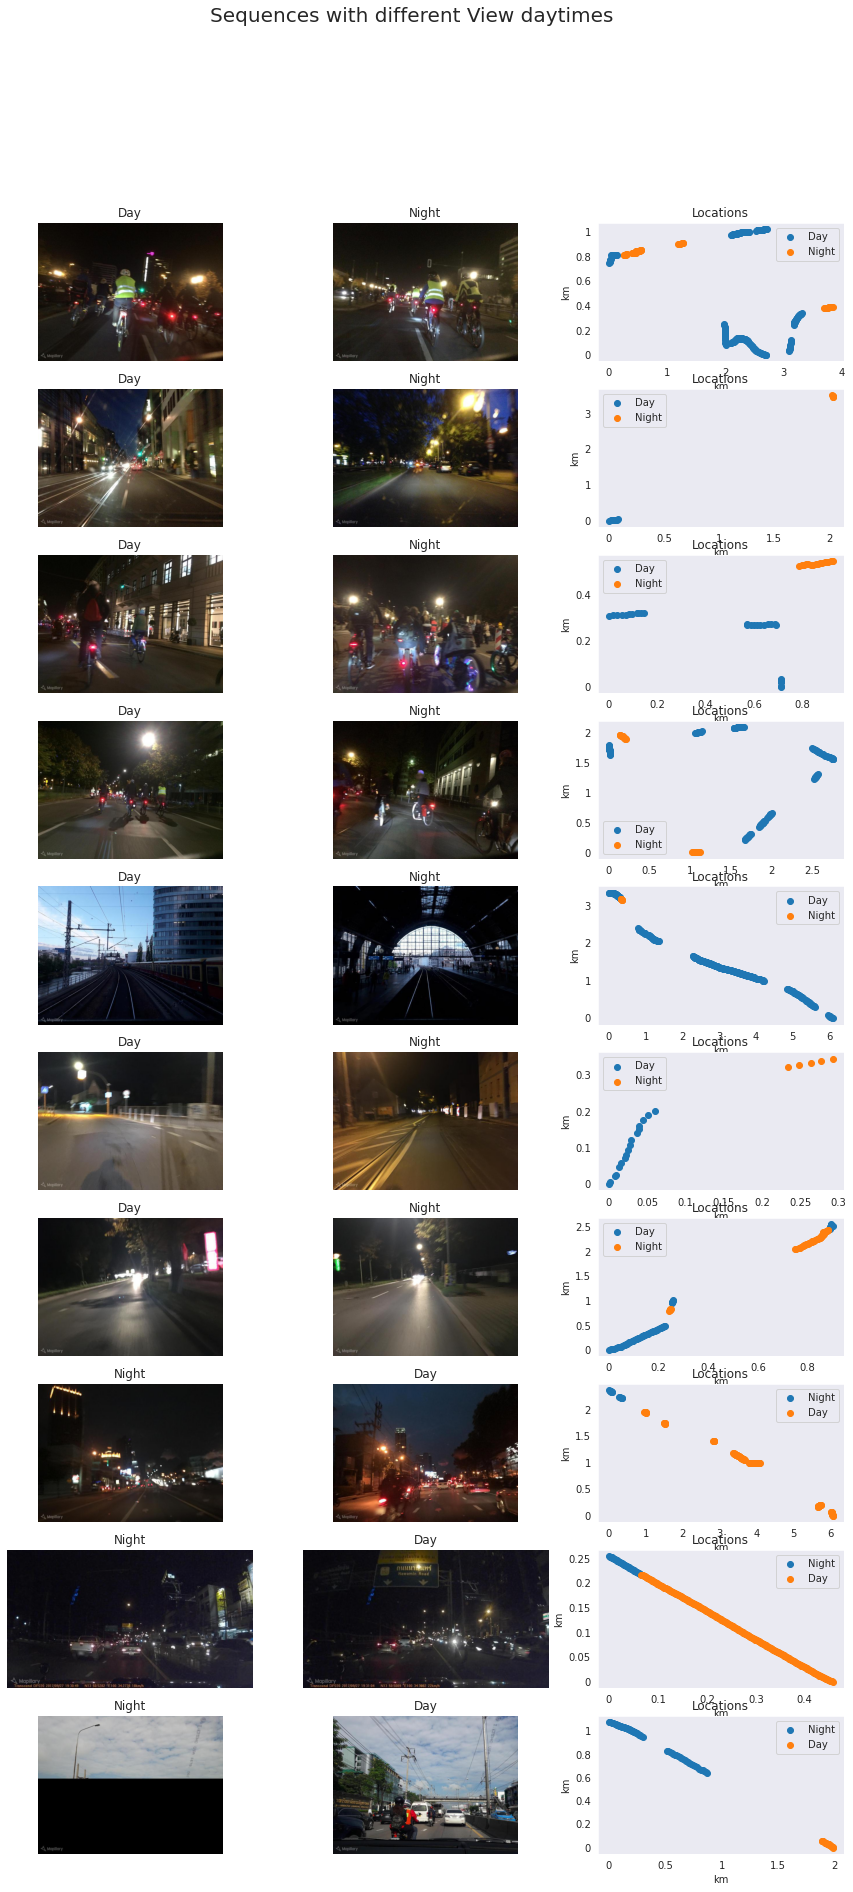

In [5]:
def join_paths(path):
    return "../" +path[0] + "/images/" + path[1] + ".jpg"

def plot_keys(n):

    fig, ax = plt.subplots(n,3,figsize=(15,3*n))

    keys = seq_dif["sequence_key"].unique()

    for i in range(n):

        key = keys[i]

        seq = seq_dif[seq_dif["sequence_key"]==key].copy()
        dirs = seq["night_name"].unique()
        img1 = join_paths(seq.loc[seq["night_name"]== dirs[0],["Path","key"]].iloc[0].values)
        img2 = join_paths(seq.loc[seq["night_name"]== dirs[1],["Path","key"]].iloc[0].values) 

        ax[i,0].imshow(plt.imread(img1))
        ax[i,0].axis('off')
        ax[i,0].set_title(dirs[0])
        ax[i,1].imshow(plt.imread(img2))
        ax[i,1].axis('off')
        ax[i,1].set_title(dirs[1])

        seq.loc[:,"easting"]-=seq["easting"].min()

        seq.loc[:,"northing"]-=seq["northing"].min()
        
        mask1 = seq["night_name"]== dirs[0]
        mask2 = seq["night_name"]== dirs[1]


        ax[i,2].scatter(seq.loc[mask1,"easting"],seq.loc[mask1,"northing"],label=dirs[0])
        ax[i,2].scatter(seq.loc[mask2,"easting"],seq.loc[mask2,"northing"],label=dirs[1])
        ax[i,2].legend()
        ax[i,2].set_title("Locations")
        m2km = lambda x, _: f'{x/1000:g}'
        ax[i,2].xaxis.set_major_formatter(m2km)
        ax[i,2].yaxis.set_major_formatter(m2km)
        ax[i,2].set_xlabel("km")
        ax[i,2].set_ylabel("km")


    plt.suptitle("Sequences with different View daytimes",fontsize = 20)
    plt.savefig("Imgs/Sequences_with_different_View_daytimes.jpg")
    plt.show()

plot_keys(10)

In [6]:
df.drop(index=seq_dif.index,inplace=True)

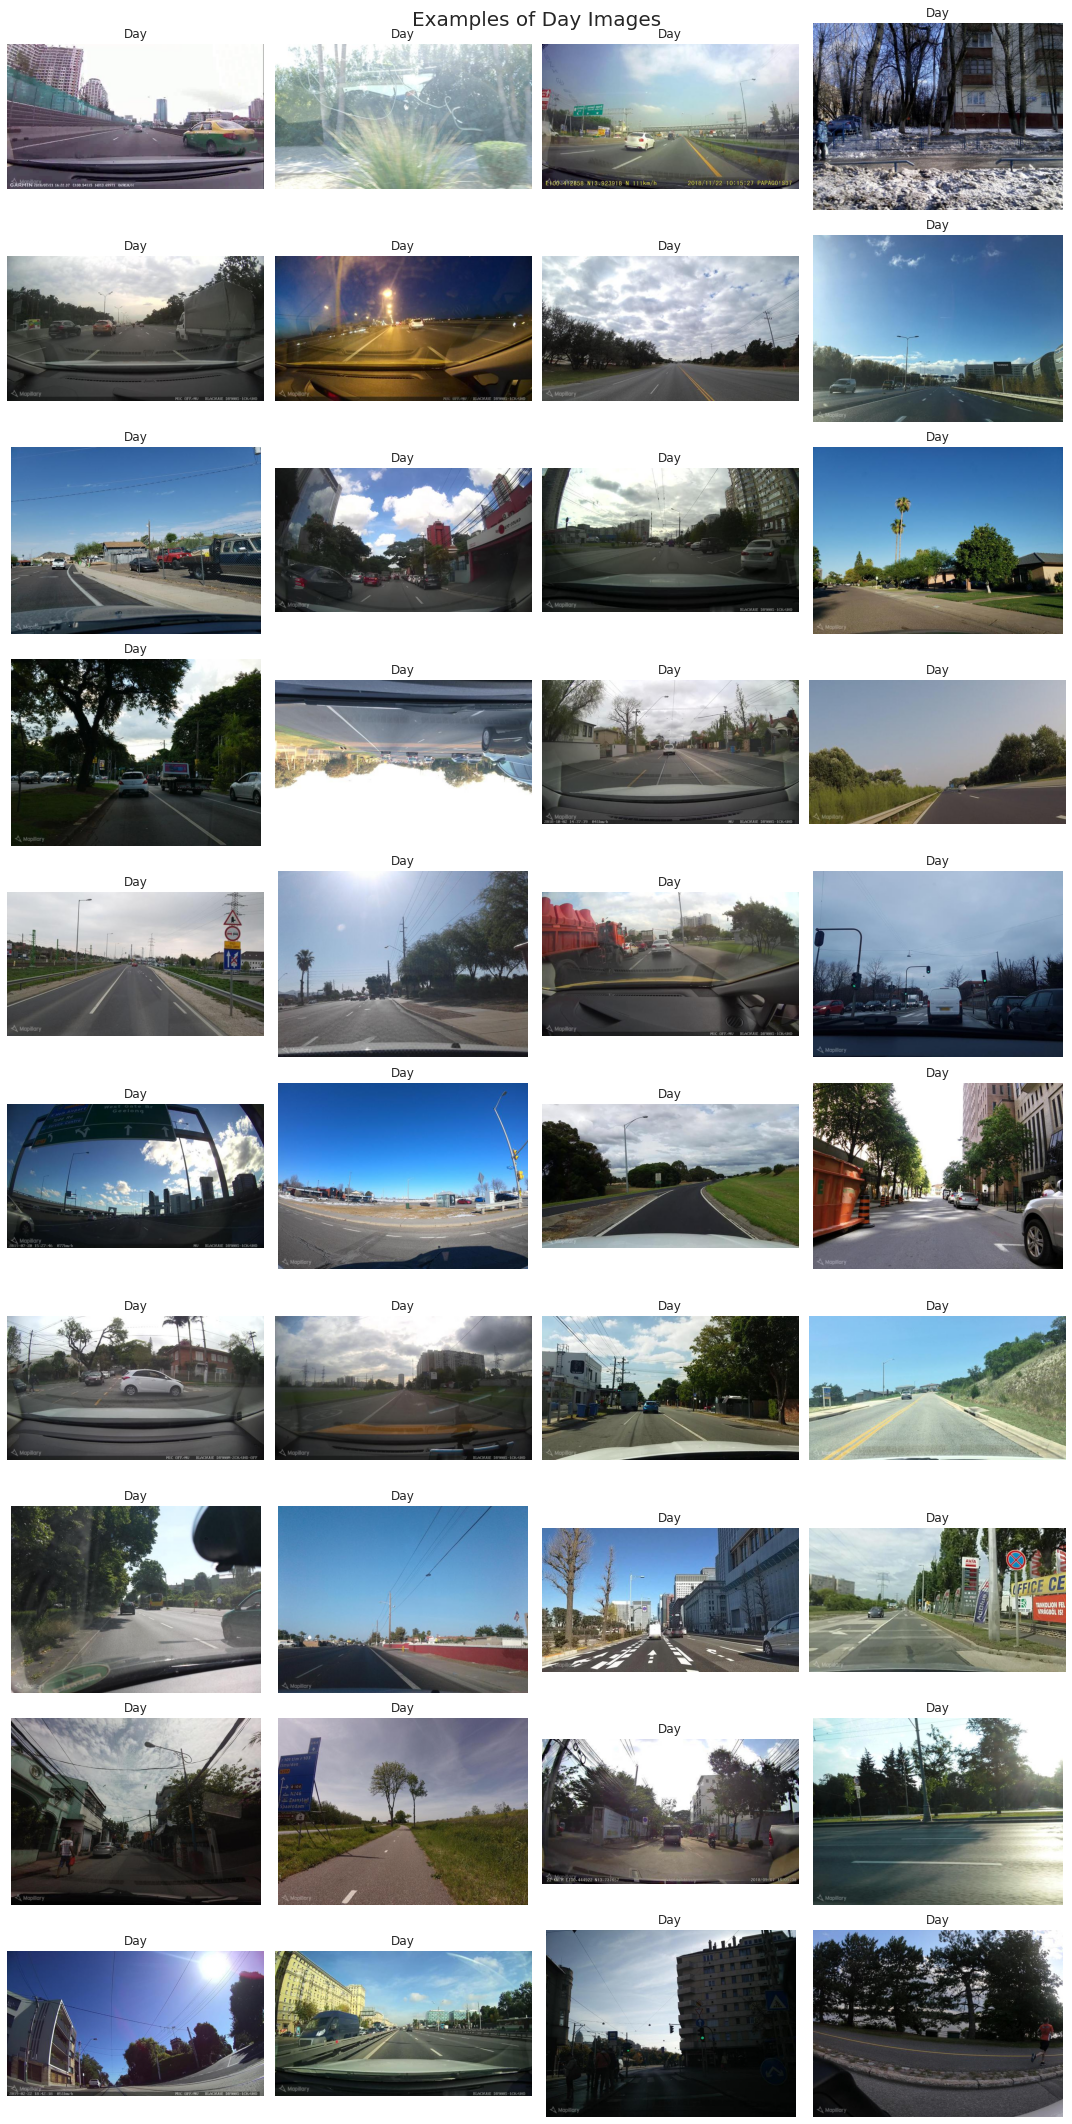

In [7]:
n_rows, n_cols = 10,4
fig, ax = plt.subplots(n_rows,n_cols,figsize=(15,3*n_rows))
indices = np.random.choice(df[df["night_name"]=="Day"].index.values,n_rows*n_cols,replace=False)

images = df.loc[indices]

ax = ax.flatten()

for i in range(n_rows*n_cols):
    
    img = images.iloc[i]
    ax[i].imshow(plt.imread(join_paths(img[["Path","key"]])))
    ax[i].axis('off')
    ax[i].set_title(img["night_name"])

plt.suptitle("Examples of Day Images",fontsize=20)
plt.savefig("Imgs/Examples_of_Day_Images.jpg")
plt.tight_layout()
plt.show()

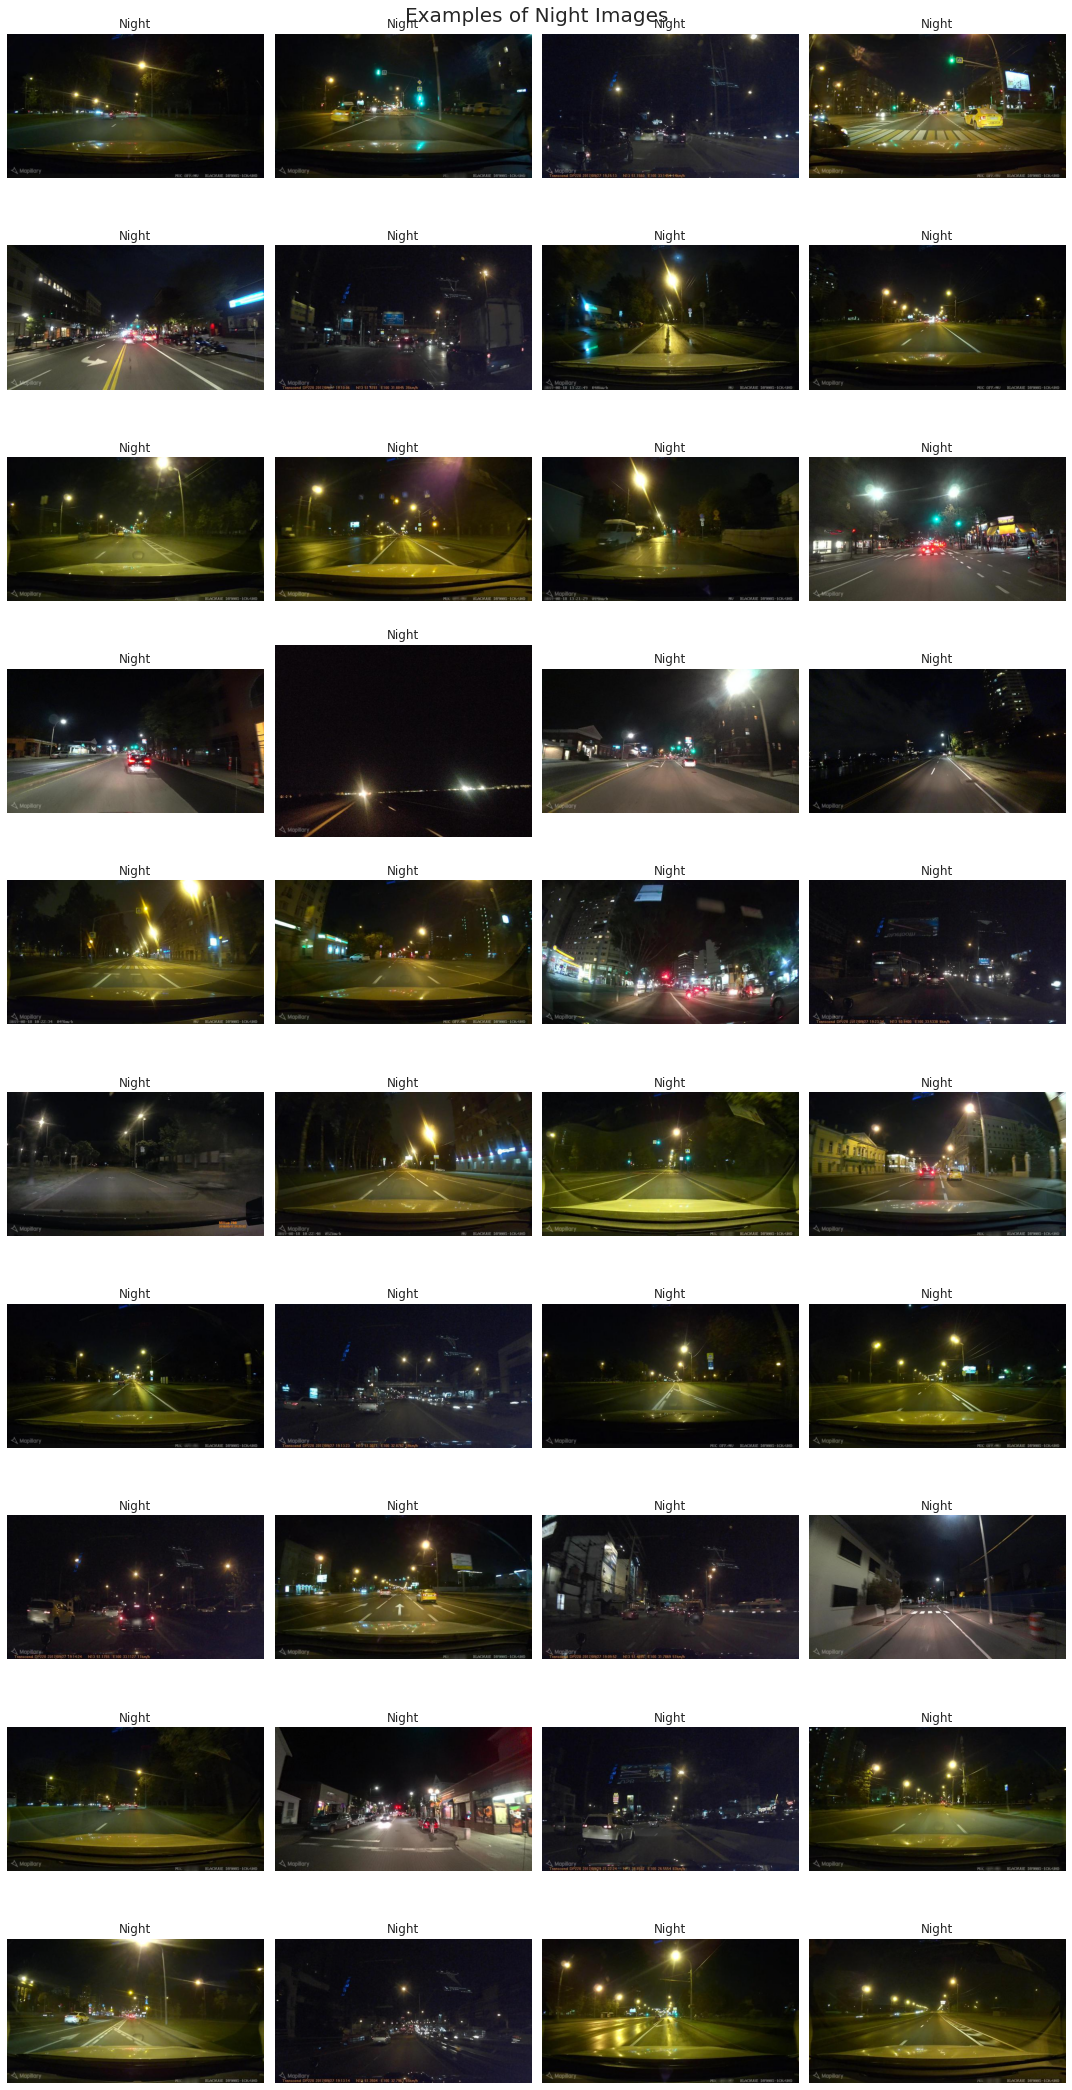

In [8]:
n_rows, n_cols = 10,4
fig, ax = plt.subplots(n_rows,n_cols,figsize=(15,3*n_rows))
indices = np.random.choice(df[df["night_name"]=="Night"].index.values,n_rows*n_cols,replace=False)

images = df.loc[indices]

ax = ax.flatten()

for i in range(n_rows*n_cols):
    
    img = images.iloc[i]
    ax[i].imshow(plt.imread(join_paths(img[["Path","key"]])))
    ax[i].axis('off')
    ax[i].set_title(img["night_name"])

plt.suptitle("Examples of Night Images",fontsize=20)
plt.savefig("Imgs/Examples_of_Night_Images.jpg")
plt.tight_layout()
plt.show()

In [9]:
city = df.groupby(["City"])["night"].count().to_frame()
l = df.value_counts(["City","night"]).to_frame()

def get_values(City):

    df =  l.loc[City].T

    vals = []
    for direction in [True,False]:

        if direction in df.columns:
            vals.append(df[direction].values[0])
        else:
            vals.append(0)

    return pd.DataFrame([vals],columns=["Night"	,"Day"],index=[City])
city = city.join(pd.concat([ get_values(i) for i in city.index]))
city.rename(columns={"night":"image_counts"},inplace=True)
city


image_counts  Night     Day
City                                  
amman              1762     63    1699
amsterdam         19432      0   19432
austin            42684      0   42684
bangkok          113890   2348  111542
berlin            70315      5   70310
boston            20559   1546   19013
budapest         198836    297  198539
cph               19196     85   19111
goa               11084      0   11084
helsinki          48476     24   48452
london             5983      0    5983
manila            11442      0   11442
melbourne        189945      0  189945
moscow           245072   4961  240111
nairobi             864      0     864
ottawa           123273      0  123273
paris             17983      0   17983
phoenix          155772    394  155378
saopaulo          53478    870   52608
sf                10840      0   10840
tokyo             60975     10   60965
toronto           20141      0   20141
trondheim          9151      0    9151
zurich             5098      0    5098

In [10]:
city["Night"].sum() * 0.2

2120.6

In [11]:
city[(city.loc[:,"Night"] > 0)]

image_counts  Night     Day
City                                 
amman             1762     63    1699
bangkok         113890   2348  111542
berlin           70315      5   70310
boston           20559   1546   19013
budapest        198836    297  198539
cph              19196     85   19111
helsinki         48476     24   48452
moscow          245072   4961  240111
phoenix         155772    394  155378
saopaulo         53478    870   52608
tokyo            60975     10   60965

In [12]:
val_citys = ["boston"]
test_citys = ["saopaulo"]
train_citys = city.drop(index=val_citys+ test_citys).index.values
city.loc[val_citys+test_citys,"Night"].sum()

2416

In [13]:
train_df_all = df.loc[df["City"].apply(lambda x: x in train_citys)]
test_df_all = df.loc[df["City"].apply(lambda x: x in test_citys)]
val_df_all = df.loc[df["City"].apply(lambda x: x in val_citys)]

In [14]:
train_df_all.value_counts("night")

night
False    1374027
True        8187
dtype: int64

In [15]:
val_df_all.value_counts("night")

night
False    19013
True      1546
dtype: int64

In [16]:
test_df_all.value_counts("night")

night
False    52608
True       870
dtype: int64

In [17]:
def drop_n_forward(df,n):

    df = df.copy()
    indeces = df[df["night"] == False].index
    keep = np.random.choice(indeces,len(indeces)-n,replace = False)
    indices_to_keep = np.concatenate([keep, df[df["night"] == True].index])
    return df.loc[indices_to_keep].copy()
train_df = drop_n_forward(train_df_all,1360000)
val_df = drop_n_forward(val_df_all,16500)
test_df = drop_n_forward(test_df_all,51000)


In [18]:
train_df.value_counts("night")

night
False    14027
True      8187
dtype: int64

In [19]:
val_df.value_counts("night")

night
False    2513
True     1546
dtype: int64

In [20]:
test_df.value_counts("night")


night
False    1608
True      870
dtype: int64

In [21]:
# shuffle ds 
train_df = train_df.sample(frac = 1, random_state= 1)
val_df = val_df.sample(frac = 1, random_state= 1)


train_df["ds_type"] = "train"
val_df["ds_type"] = "val"
test_df["ds_type"] = "test"

In [22]:
df = pd.concat([train_df,val_df,test_df])
df.drop(columns=["Unnamed: 0_x","unique_cluster","pano","Unnamed: 0_y","frame_number","control_panel","night"],inplace=True)
df.index = range(len(df))
df.to_csv("nights_data.csv")

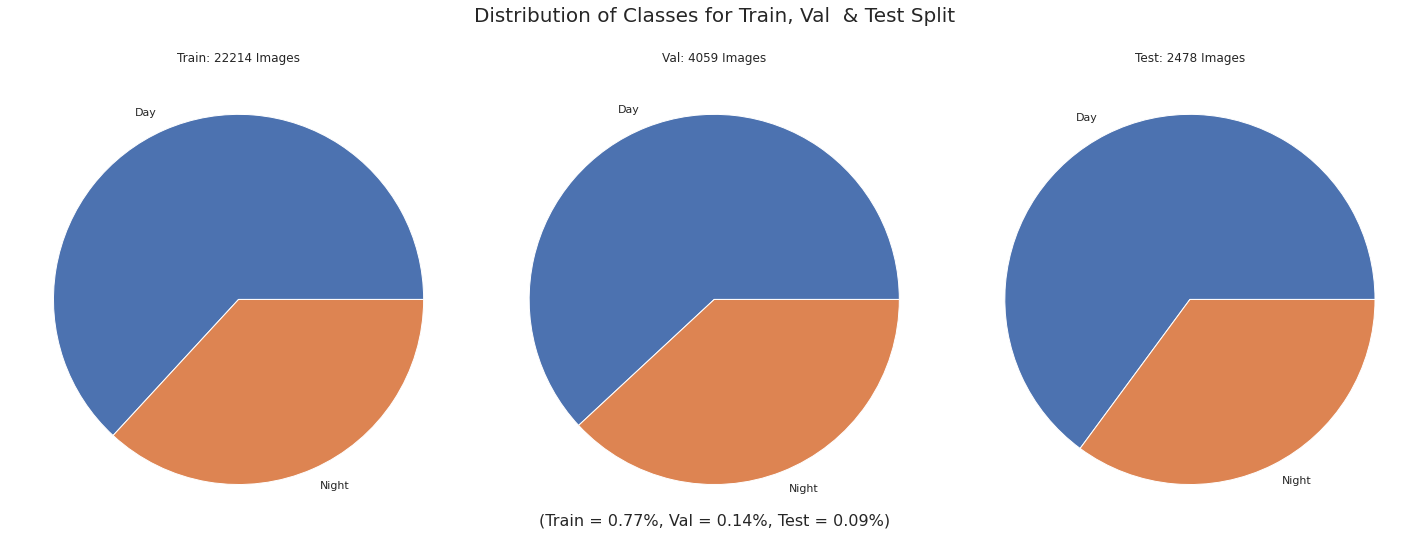

In [23]:
sns.set_theme()
def plot_pie(df,ax):

    x = df["night_name"].value_counts()

    ax.pie(x.values,labels = x.index )

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Images')
ax[1].title.set_text(f'Val: {len(val_df)} Images')
ax[2].title.set_text(f'Test: {len(test_df)} Images')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1])
plot_pie(test_df,ax[2])
plt.suptitle(f"Distribution of Classes for Train, Val  & Test Split",fontsize=20)
plt.tight_layout()
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(df):.2f}%, Val = {len(val_df)/len(df):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
plt.savefig("Imgs/Training_Split.jpg")
plt.show()

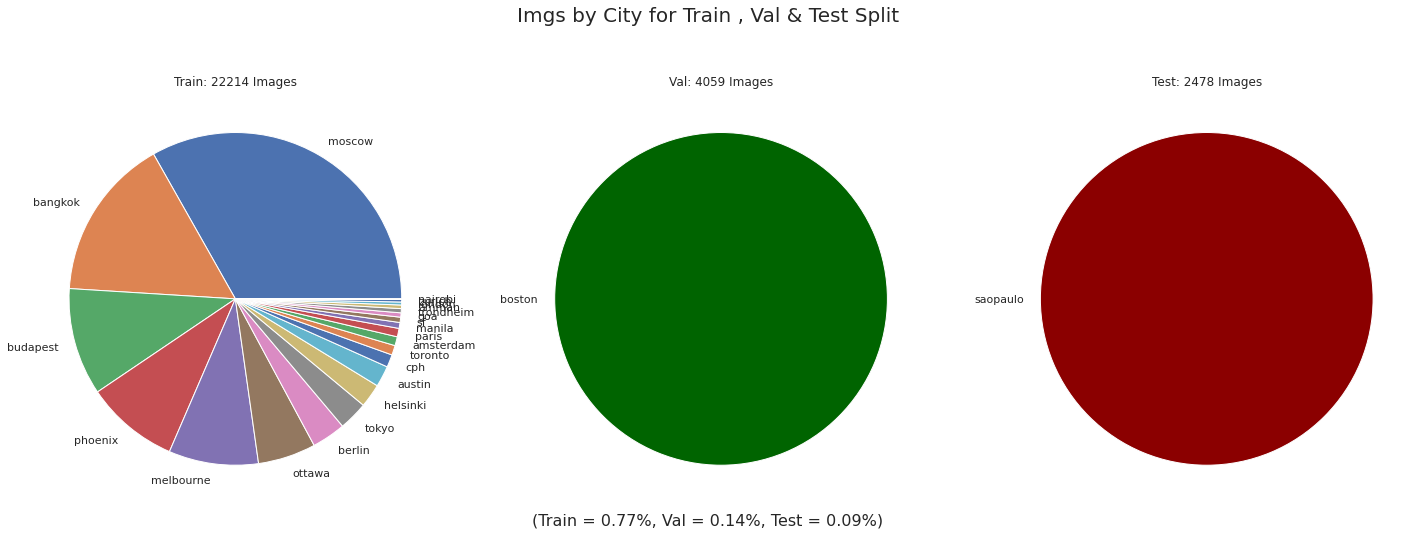

In [24]:
def plot_pie(df,ax,colors = None):

    x = df["City"].value_counts()

    ax.pie(x.values,labels = x.index ,colors = colors)

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Images')
ax[1].title.set_text(f'Val: {len(val_df)} Images')
ax[2].title.set_text(f'Test: {len(test_df)} Images')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1],colors=["darkgreen"])
plot_pie(test_df,ax[2],colors=["darkred"])
plt.suptitle(f"Imgs by City for Train , Val & Test Split", fontsize=20)
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(df):.2f}%, Val = {len(val_df)/len(df):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
plt.tight_layout()
plt.savefig("Imgs/Citys_Split.jpg")
plt.show()

In [28]:
#done  
df.value_counts("ds_type")

ds_type
train    22214
val       4059
test      2478
dtype: int64

In [30]:
df.value_counts("ds_type")

ds_type
train    22214
val       4059
test      2478
dtype: int64